# mcu_data_management
This notebook contains light EDA and visualizations, as well as the pipeline functions for automatically populating data in specific Test/Train split configurations.

In [1]:
import sys
import os
sys.path.append('site-packages') # manually put all packages/libraries into this folder
from distutils.dir_util import copy_tree
from shutil import copy, move, rmtree
import random
import matplotlib.pyplot as plt
import pandas as pd

## View Information for Each Movie's Directory
Each movie has its own directory, and each of those directories has a folder for **mcu** and **non-mcu**.

In [2]:
working_directory = 'movie_frames'

In [3]:
%ls movie_frames/

american_bistro/     gemini/                 parts_you_lose/
animals/             glory_road/             plus_one/
ballon/              hobbs_shaw/             preggoland/
black_and_blue/      hustle/                 ready_or_not/
booksmart/           jay_silent_bob_reboot/  saint_judy/
boy/                 john_wick_3/            think_like_a_man/
breakthrough/        lying_stealing/         unearthed/
brooklyn/            ma/                     valentine/
children_of_men/     madea_funeral/          vault/
downton_abbey/       midnight_in_paris/      warriors_way/
drillbit_taylor/     mollys_game/            what_still_remains/
extremely_loud/      monte_carlo/            yesterday/
fishermans_friends/  no_escape/
ford_v_ferrari/      parasite/


In [4]:
def get_frame_counts(working_directory):
    mcu_count = 0
    non_mcu_count = 0
    unlabeled_count = 0
    
    # get list of each movie directory
    movie_directories = os.listdir(working_directory)
    
    # iterate through each film and designate the directory, then count number of frames in each category
    for movie in movie_directories:
        movie_folder = os.path.join(working_directory, movie)
        mcu_folder = os.path.join(working_directory, movie, 'mcu')
        non_mcu_folder = os.path.join(working_directory, movie, 'non_mcu')

        unlabeled_count += len(os.listdir(movie_folder)) - 2
        mcu_count += len(os.listdir(mcu_folder))
        non_mcu_count += len(os.listdir(non_mcu_folder))
        
    print('There are', mcu_count, 'MCU frames')
    print('There are', non_mcu_count, 'non-MCU frames')
    print('There are', unlabeled_count, 'unlabeled frames')

    return mcu_count, non_mcu_count, unlabeled_count

In [5]:
# return a simple total of all types of frames
mcu_count, non_mcu_count, unlabeled_count = get_frame_counts(working_directory)

There are 3023 MCU frames
There are 8409 non-MCU frames
There are 21328 unlabeled frames


## Creating a DataFrame for MCU/non-MCU counts
For the purposes of creating a dataframe, we can store the counts of MCUs and non-MCUs for each film, as well as the movie title.

In [6]:
def generate_movie_labels(working_directory):
    mcu_frames_univ = []
    non_frames_univ = []
    movies = []
    
    # get list of each movie directory
    movie_directories = os.listdir(working_directory)
    
    # iterate through each film and designate the directory, then count number of frames in each category
    for movie in movie_directories:
        movie_folder = os.path.join(working_directory, movie)
        mcu_folder = os.path.join(movie_folder, 'mcu')
        non_mcu_folder = os.path.join(movie_folder, 'non_mcu')
        
        # create lists for use in pandas dataframe
        mcu_frames_univ.append(len(os.listdir(mcu_folder)))
        non_frames_univ.append(len(os.listdir(non_mcu_folder)))
        movies.append(movie)
        
        # count type of frame for print
        mcu_frames = len(os.listdir(mcu_folder))
        non_mcu_frames = len(os.listdir(non_mcu_folder))
        unlabeled_frames = len(os.listdir(movie_folder)) - 2

        # calculate percentages
        labeled_percentage = '{0:.2f}%'.format((mcu_frames + non_mcu_frames) / ((mcu_frames + non_mcu_frames + unlabeled_frames)) * 100)
        try:
            mcu_percentage = '{0:.2f}%'.format(mcu_frames / (mcu_frames + non_mcu_frames) * 100)
            non_mcu_percentage = '{0:.2f}%'.format(non_mcu_frames / (mcu_frames + non_mcu_frames) * 100)
        except ZeroDivisionError:
            mcu_percentage = '0.00%'
            non_mcu_percentage = '0.00%'
        
        # informational text
        print(movie + ', frames labeled:', labeled_percentage)
        print('\tMCU frames:\t\t', mcu_frames, '\t', mcu_percentage)
        print('\tNon-MCU frames:\t\t', non_mcu_frames, '\t', non_mcu_percentage)
        print('\tUnlabeled frames:\t', unlabeled_frames)
    
    return movies, mcu_frames_univ, non_frames_univ

In [7]:
# store lists of movie title, its count of MCUs, and count of non-MCUs
movies, mcu_frames_univ, non_frames_univ = generate_movie_labels(working_directory)

fishermans_friends, frames labeled: 27.45%
	MCU frames:		 54 	 23.48%
	Non-MCU frames:		 176 	 76.52%
	Unlabeled frames:	 608
preggoland, frames labeled: 23.43%
	MCU frames:		 41 	 21.13%
	Non-MCU frames:		 153 	 78.87%
	Unlabeled frames:	 634
boy, frames labeled: 26.87%
	MCU frames:		 53 	 26.77%
	Non-MCU frames:		 145 	 73.23%
	Unlabeled frames:	 539
breakthrough, frames labeled: 28.60%
	MCU frames:		 54 	 21.60%
	Non-MCU frames:		 196 	 78.40%
	Unlabeled frames:	 624
warriors_way, frames labeled: 33.47%
	MCU frames:		 79 	 31.23%
	Non-MCU frames:		 174 	 68.77%
	Unlabeled frames:	 503
hustle, frames labeled: 31.36%
	MCU frames:		 97 	 43.69%
	Non-MCU frames:		 125 	 56.31%
	Unlabeled frames:	 486
extremely_loud, frames labeled: 39.24%
	MCU frames:		 92 	 24.02%
	Non-MCU frames:		 291 	 75.98%
	Unlabeled frames:	 593
midnight_in_paris, frames labeled: 37.71%
	MCU frames:		 53 	 19.85%
	Non-MCU frames:		 214 	 80.15%
	Unlabeled frames:	 441
downton_abbey, frames labeled: 35.75%
	MCU f

In [8]:
# create DataFrame
arrays = [movies, mcu_frames_univ, non_frames_univ]
frames_df = pd.DataFrame(data = arrays).T
frames_df.columns = ['movie_title', 'mcu', 'non-mcu']

In [9]:
frames_df.head(2)

,movie_title,mcu,non-mcu
0,fishermans_friends,54,176
1,preggoland,41,153


In [10]:
frames_df.shape

(40, 3)

## Visualizing Counts
Though the primary data are the image files themselves, we can gain some insight by visualizing the counts of each category. There's a heavy class imbalance: 26% vs. 74%.

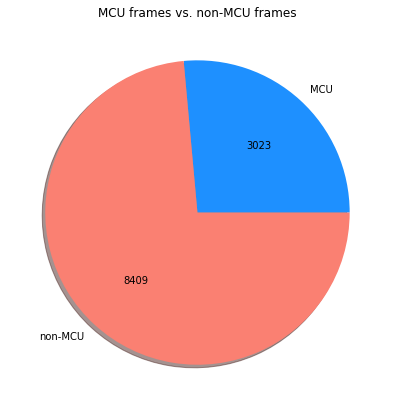

In [13]:
ax = frames_df[['mcu','non-mcu']].sum().plot.pie(figsize=(15,7), colors = ['dodgerblue', 'salmon'], shadow=True, autopct=lambda p: '{:.0f}'.format(p * frames_df[['mcu','non-mcu']].sum().sum() / 100), labels = ['MCU', 'non-MCU'])
ax.set_title('MCU frames vs. non-MCU frames')
plt.axis('off')
plt.show()

We can see MCUs vs. non-MCUs, as well as the movies for which I spent the most effort labelling.

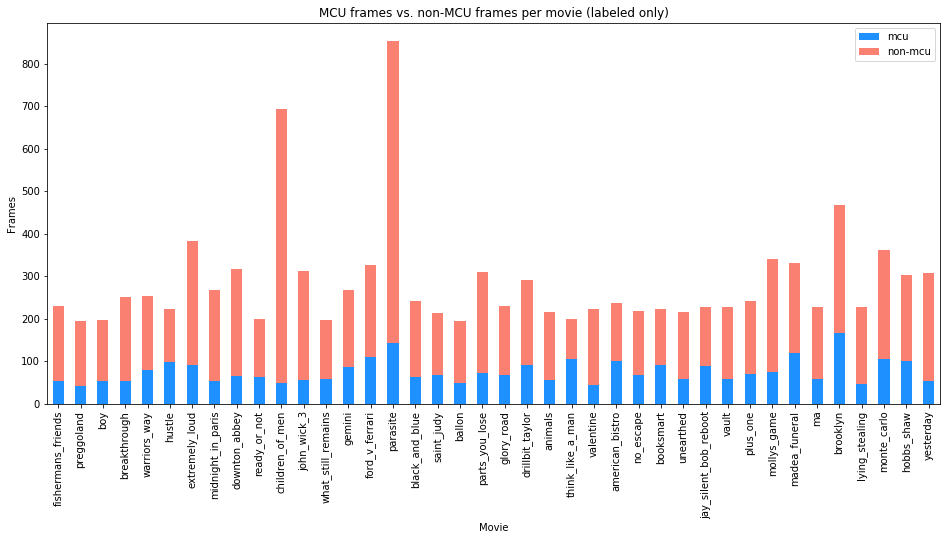

In [20]:
ax = frames_df.plot.bar(stacked=True, color = ['dodgerblue', 'salmon'], figsize=(16,7))
ax.set_title('MCU frames vs. non-MCU frames per movie (labeled only)')
ax.set_xlabel('Movie')
ax.set_xticklabels(frames_df.movie_title)
ax.set_ylabel('Frames')
plt.xticks(rotation=90)
plt.show()

We can create a new dataframe containing the percentage of MCUs per film.

In [21]:
frames_eda_df = frames_df.copy()
frames_eda_df['mcu_percentage'] = frames_eda_df['mcu'] / (frames_eda_df['mcu'] + frames_eda_df['non-mcu'])
frames_eda_df = frames_eda_df.sort_values('mcu_percentage', ascending = False).reset_index(drop=True)

In [22]:
frames_eda_df.head(2)

,movie_title,mcu,non-mcu,mcu_percentage
0,think_like_a_man,105,95,0.525
1,hustle,97,125,0.436937


This plot shows each film's percentage of MCU frames. Four of the five films with the highest percentages are high-budget comedy films. These kinds of films are mostly just vehicles for their stars, and don't deviate from the formula of using standard two-character dialogue scenes for stars to quip jokes at one another.

On the other end of the spectrum is Children of Men, which employed a naturalistic, distant, method of filming. This percentage is also impacted by its multiple long-take scenes, including the seven-minute, video-game-like climax. No frames from these scenes constituted MCUs.

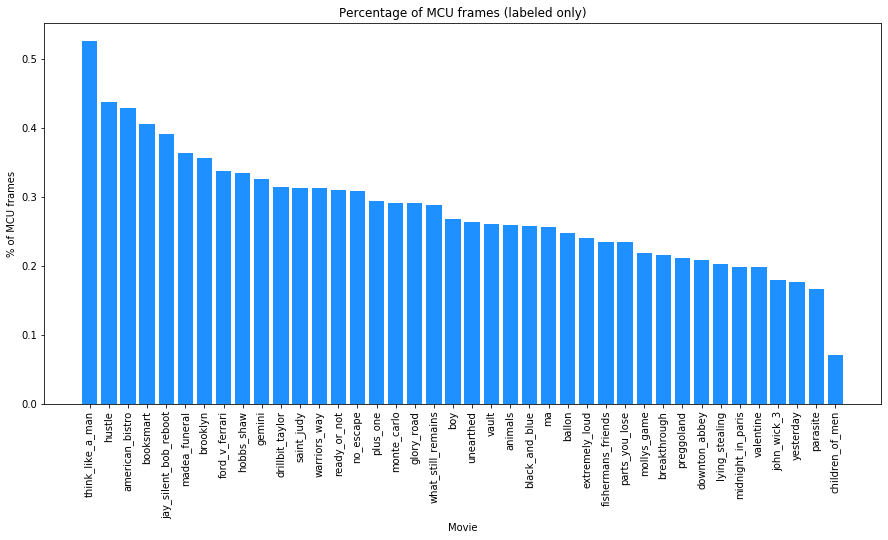

In [23]:
fig = plt.figure(figsize = (15,7))
ax = fig.gca()
ax.bar(frames_eda_df['movie_title'], frames_eda_df['mcu_percentage'], color = ['dodgerblue'])
ax.set_title('Percentage of MCU frames (labeled only)')
plt.xticks(rotation=90)
ax.set_xlabel('Movie')
ax.set_ylabel('% of MCU frames')
plt.show()

## Populating Test/Train Data
These functions were written to automatically pull frames from each movie's MCU/non-MCU folders and populate them in new folders for a Test/Train split.
### Split Configuration 1: "Mixed Frames" Testing on frames from all movies
This shuffles frames from all 40 films into a random split of 80% Train and 20% Test. This is the primary configuration used for preliminary training, as it allows for the most variety in frames for training.

In [14]:
def populated_mixed_movies(working_directory, copy_directory, test_split, imbalance_removal):
    
    movie_directories = os.listdir(working_directory)
    
    # delete existing directories and files
    rmtree(os.path.join('mcu_data', copy_directory, 'train'))
    rmtree(os.path.join('mcu_data', copy_directory, 'test'))
    
    # create file structure
    os.mkdir(os.path.join('mcu_data', copy_directory, 'train'))
    os.mkdir(os.path.join('mcu_data', copy_directory, 'train/mcu'))
    os.mkdir(os.path.join('mcu_data', copy_directory, 'train/non_mcu'))
    os.mkdir(os.path.join('mcu_data', copy_directory, 'test'))
    os.mkdir(os.path.join('mcu_data', copy_directory, 'test/mcu'))
    os.mkdir(os.path.join('mcu_data', copy_directory, 'test/non_mcu'))
    
    # create variables for use within function 
    train_mcu_folder = os.path.join('mcu_data', copy_directory, 'train/mcu')
    train_non_folder = os.path.join('mcu_data', copy_directory, 'train/non_mcu')
    test_mcu_folder = os.path.join('mcu_data', copy_directory, 'test/mcu')
    test_non_folder = os.path.join('mcu_data', copy_directory, 'test/non_mcu')
    
    # move frames from each movie directory into Train's mcu and non_mcu folders
    for movie in movie_directories:
        movie_folder = os.path.join(working_directory, movie)
        mcu_folder = os.path.join(movie_folder, 'mcu')
        target_mcu_folder = os.path.join('mcu_data', copy_directory, 'train/mcu')  
        non_folder = os.path.join(movie_folder, 'non_mcu')
        target_non_folder = os.path.join('mcu_data', copy_directory, 'train/non_mcu')
        copy_tree(mcu_folder, target_mcu_folder)
        copy_tree(non_folder, target_non_folder)
    
    # take a random sample (test_split) of frames in Train and move to Test, for both mcu and non_mcu
    for frame in random.sample(os.listdir(train_mcu_folder), int(len(os.listdir(train_mcu_folder)) * test_split)):
        move(os.path.join(train_mcu_folder, frame), test_mcu_folder)
    for frame in random.sample(os.listdir(train_non_folder), int(len(os.listdir(train_non_folder)) * test_split)):
        move(os.path.join(train_non_folder, frame), test_non_folder)
    
    # remove certain percentage(imbalance_removal) of non-mcu frames from Train, because of class imbalance
    for frame in random.sample(os.listdir(train_non_folder), int(len(os.listdir(train_non_folder)) * imbalance_removal)):
        os.remove(os.path.join(train_non_folder, frame))
    
    # informational text
    print('Moved', len(os.listdir(train_mcu_folder)), 'MCU images into Train')
    print('Moved', len(os.listdir(train_non_folder)), 'non-MCU images into Train')
    print('Moved', len(os.listdir(test_mcu_folder)), 'MCU images into Test')
    print('Moved', len(os.listdir(test_non_folder)), 'non-MCU images into Test')

This function allows for the removal of non-MCU images from the Training set, to mitigate class imbalance. Three of these datasets were created: removing 20%, 40%, and 60% of non-MCUs from Train.

In [15]:
copy_directory = 'mixed_frames_remove_20'
populated_mixed_movies(working_directory, copy_directory, test_split=.2, imbalance_removal=.2)

Moved 2419 MCU images into Train
Moved 5383 non-MCU images into Train
Moved 604 MCU images into Test
Moved 1681 non-MCU images into Test


In [16]:
copy_directory = 'mixed_frames_remove_40'
populated_mixed_movies(working_directory, copy_directory, test_split=.2, imbalance_removal=.4)

Moved 2419 MCU images into Train
Moved 4037 non-MCU images into Train
Moved 604 MCU images into Test
Moved 1681 non-MCU images into Test


In [17]:
copy_directory = 'mixed_frames_remove_60'
populated_mixed_movies(working_directory, copy_directory, test_split=.2, imbalance_removal=.6)

Moved 2419 MCU images into Train
Moved 2692 non-MCU images into Train
Moved 604 MCU images into Test
Moved 1681 non-MCU images into Test


### Split Configuration 2: Keeping "Unseen" movies' frames out of Train, and exclusively Testing on these movies
This randomly splits the films into 32 Train and 8 Test movies; each film's frames will only be in Train OR Test. This simulates the testing of the model on films it hasn't watched before, but at this early stage of training, the 25% increase in frame variety is more important.

In [32]:
def populated_unseen_movies(working_directory, copy_directory, test_movies, imbalance_removal):
    
    movie_directories = os.listdir(working_directory)
    
    # delete existing directories and files
    rmtree(os.path.join('mcu_data', copy_directory, 'train'))
    rmtree(os.path.join('mcu_data', copy_directory, 'test'))
    
    # create file structure
    os.mkdir(os.path.join('mcu_data', copy_directory, 'train'))
    os.mkdir(os.path.join('mcu_data', copy_directory, 'train/mcu'))
    os.mkdir(os.path.join('mcu_data', copy_directory, 'train/non_mcu'))
    os.mkdir(os.path.join('mcu_data', copy_directory, 'test'))
    os.mkdir(os.path.join('mcu_data', copy_directory, 'test/mcu'))
    os.mkdir(os.path.join('mcu_data', copy_directory, 'test/non_mcu'))
    
    # create variables for use within function 
    train_mcu_folder = os.path.join('mcu_data', copy_directory, 'train/mcu')
    train_non_folder = os.path.join('mcu_data', copy_directory, 'train/non_mcu')
    test_mcu_folder = os.path.join('mcu_data', copy_directory, 'test/mcu')
    test_non_folder = os.path.join('mcu_data', copy_directory, 'test/non_mcu')
    
    # create new list for "unseen" movies to serve as the Test set, and avoid populating these in Train
    test_directories = random.sample(movie_directories, test_movies)
    for movie in test_list:
        movie_directories.remove(movie)
    
    # move frames from each movie directory into Train's mcu and non_mcu folders
    for movie in movie_directories:
        movie_folder = os.path.join(working_directory, movie)
        mcu_folder = os.path.join(movie_folder, 'mcu')
        target_mcu_folder = os.path.join('mcu_data', copy_directory, 'train/mcu')  
        non_folder = os.path.join(movie_folder, 'non_mcu')
        target_non_folder = os.path.join('mcu_data', copy_directory, 'train/non_mcu')
        copy_tree(mcu_folder, target_mcu_folder)
        copy_tree(non_folder, target_non_folder)
    
    # move frames from each movie directory into Test's mcu and non_mcu folders
    for movie in test_directories:
        movie_folder = os.path.join(working_directory, movie)
        mcu_folder = os.path.join(movie_folder, 'mcu')
        target_mcu_folder = os.path.join('mcu_data', copy_directory, 'test/mcu')  
        non_folder = os.path.join(movie_folder, 'non_mcu')
        target_non_folder = os.path.join('mcu_data', copy_directory, 'test/non_mcu')
        copy_tree(mcu_folder, target_mcu_folder)
        copy_tree(non_folder, target_non_folder)
        
    # remove certain percentage(imbalance_removal) of non-mcu frames from Train, because of class imbalance
    for frame in random.sample(os.listdir(train_non_folder), int(len(os.listdir(train_non_folder)) * imbalance_removal)):
        os.remove(os.path.join(train_non_folder, frame))
    
    # informational text
    print('Moved', len(os.listdir(train_mcu_folder)), 'MCU images into Train')
    print('Moved', len(os.listdir(train_non_folder)), 'non-MCU images into Train')
    print('Moved', len(os.listdir(test_mcu_folder)), 'MCU images into Test')
    print('Moved', len(os.listdir(test_non_folder)), 'non-MCU images into Test')
    print('\nThe following films', test_movies, 'are in the testing set:')
    for movie in test_directories:
        print(movie)

In [33]:
copy_directory = 'unseen_frames_remove_60'
populated_unseen_movies(working_directory, copy_directory, test_movies=8, imbalance_removal=.6)

Moved 2891 MCU images into Train
Moved 3236 non-MCU images into Train
Moved 674 MCU images into Test
Moved 1684 non-MCU images into Test

The following films 8 are in the testing set:
brooklyn
parts_you_lose
animals
madea_funeral
extremely_loud
ballon
black_and_blue
unearthed
